In [41]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage 
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode,tools_condition


In [42]:
class State(TypedDict):
    messages : Annotated[list,add_messages]

In [43]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [44]:
api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="llama3-70b-8192")

In [45]:
api_key_tavily = os.getenv("TAVILY_API_KEY")
from langchain_tavily import TavilySearch
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("Who is the Indian Prime Minister")

{'query': 'Who is the Indian Prime Minister',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Know the PM - Prime Minister of India',
   'url': 'https://www.pmindia.gov.in/en/pms-profile/',
   'content': 'Image 9: PM IndiaShri Narendra Modi was sworn-in as India’s Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. The first ever Prime Minister to be born after Independence, Shri Modi has previously served as the Prime Minister of India from 2014 to 2019, and from 2019 to 2024. Leading international agencies have noted that under the leadership of PM Narendra Modi, India has been eliminating poverty at record pace. Shri Modi believes that no Indian should be homeless and to realise this vision, over 4.2 crore houses were sanctionedunder the PM Awas Yojana between 2014 and 2024. PM Modi launched the ‘Make in India’ initiative to turn India into an international manufacturing pow

In [46]:
def multiply(a:int,b:int) -> int:
    """Multiply a and b

    Args:
        a (int) : first int
        b (int) : second int
    
    Returns:
        int : output int    
    """
    return a*b

In [47]:
tools = [tool,multiply]
tools

[TavilySearch(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********'))),
 <function __main__.multiply(a: int, b: int) -> int>]

In [48]:
llm_with_tools = llm.bind_tools(tools)

In [49]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a97c151eea0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a97c15427e0>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of doma

In [50]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

In [51]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [52]:
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

In [53]:
graph_builder.add_edge(START,"tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
graph_builder.add_edge("tools",END)


In [54]:
graph = graph_builder.compile()

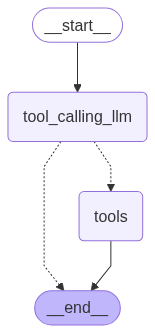

In [55]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [56]:
response = graph.invoke({"messages":"What is the recent AI news"})

In [57]:
response["messages"]

[HumanMessage(content='What is the recent AI news', additional_kwargs={}, response_metadata={}, id='08c7ddf4-8b18-459f-93b3-52ec5807981f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qenz62td1', 'function': {'arguments': '{"include_images":false,"query":"recent AI news","search_depth":"advanced","time_range":"week","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 2194, 'total_tokens': 2267, 'completion_time': 0.25895588, 'prompt_time': 0.085388309, 'queue_time': 0.05816655100000001, 'total_time': 0.344344189}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--24743514-7322-497e-929d-215fb77a1008-0', tool_calls=[{'name': 'tavily_search', 'args': {'include_images': False, 'query': 'recent AI news', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'news'}, 'id': 'qenz62td1', 'type': '

In [58]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (qenz62td1)
 Call ID: qenz62td1
  Args:
    include_images: False
    query: recent AI news
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.newsweek.com/nw-ai/ai-impact-awards-2025-science-engineering-2084754", "title": "AI Impact Awards 2025: The Changing Human Role in Science and Engineering - Newsweek", "score": 0.7251239, "published_date": "Wed, 25 Jun 2025 10:02:01 GMT", "content": "Newsweek _\\_will continue the conversation on meaningful AI innovations at our AI Impact Summit from June 23 to 25 in Sonoma, California. Click here to 

In [59]:
response2 = graph.invoke({"messages":"What is the 5 multiplied by 6"})

In [60]:
response2

{'messages': [HumanMessage(content='What is the 5 multiplied by 6', additional_kwargs={}, response_metadata={}, id='583f12db-98f7-4e7b-a1f5-795ee000ff19'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 't9ack1dzj', 'function': {'arguments': '{"a":5,"b":6}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 2197, 'total_tokens': 2245, 'completion_time': 0.165913305, 'prompt_time': 0.093228173, 'queue_time': 0.05595350700000001, 'total_time': 0.259141478}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cf5334cb-c1c5-4ea6-8d3b-1bc7755ea8a7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 6}, 'id': 't9ack1dzj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2197, 'output_tokens': 48, 'total_tokens': 2245}),
  ToolMessage(content='30', name='multiply', id='e2bb823d-1994-4d7a-b89b-17de28ae5daf', tool_ca

In [61]:
for m in response2["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the 5 multiplied by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (t9ack1dzj)
 Call ID: t9ack1dzj
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: multiply

30
